Assignment 10 Supplementary: Semantic Search Demo
===============

This Python notebook guides you through the code for Text-to-Image and Image-to-Image search.

Prior to starting, you should have a file called `image_embeddings.pickle` and a file called `coco_images_resized.zip` in the current directory.

First, unzip `coco_images_resized.zip`. This directory contains the images that you will search through.

This assignment uses pretrained CLIP (Contrastive Language Image Pretrained) models to embed text and images into a joint embedding space. You can read about CLIP models here: https://www.pinecone.io/learn/clip-image-search/

**Your end goal is to find the most relevant images given either an image or a text query.**

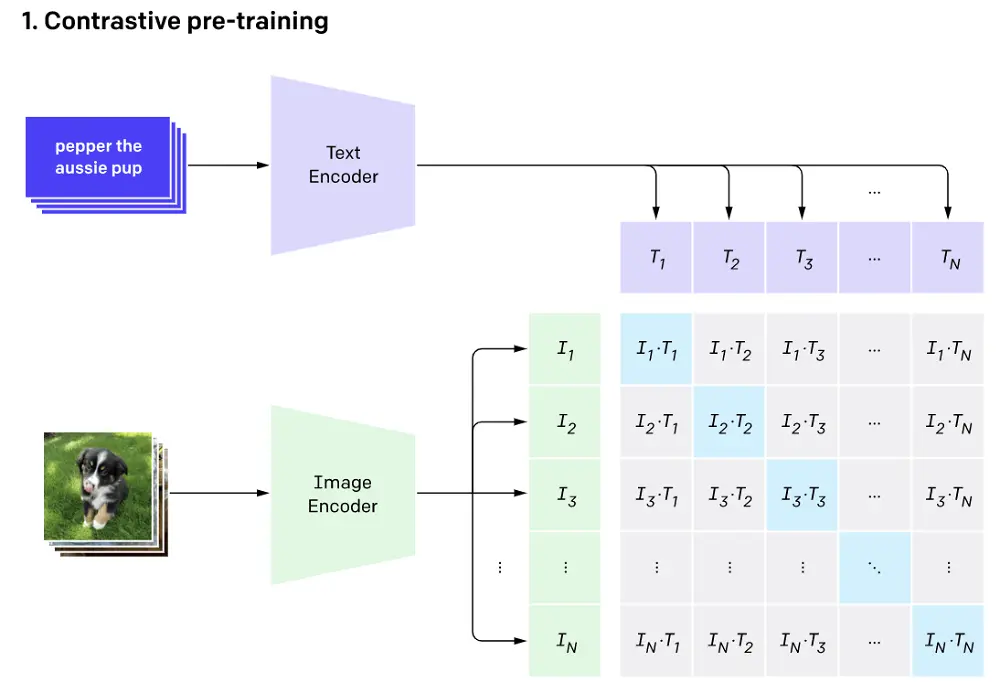

### Step 1: Caclulate Image Embeddings for Dataset

We first want to make our image database easily searchable. To achieve this, we calculate the image embedding for each image using the image encoder. **This has already been done for you,** because it is computationally intensive. Below is the code for reference.

In [ ]:
import os
import torch
import torchvision.transforms as transforms
from PIL import Image
from open_clip import create_model_and_transforms, tokenizer
import torch.nn.functional as F
import pandas as pd
from tqdm import tqdm

# Configuration
device = "cuda" if torch.cuda.is_available() else "cpu"
model_name = "ViT-B/32"
pretrained = "openai"
batch_size = 128
image_folder = "/scratch/cliao25/train2014/train2014"  # Replace with your folder path

# Load the model and preprocess function
model, preprocess_train, preprocess_val = create_model_and_transforms(model_name, pretrained=pretrained) # Create CLIP model
model = model.to(device)
model.eval()

# Image transformations (using preprocess_val from open_clip)
transform = preprocess_val

# Collect all image paths
image_paths = [os.path.join(image_folder, fname) for fname in os.listdir(image_folder) if fname.lower().endswith(('.png', '.jpg', '.jpeg'))]
print('Number of images:', len(image_paths))
# DataFrame to store results
results = []

# Function to load and preprocess images
def load_images(batch_paths):
    images = []
    for path in batch_paths:
        try:
            image = Image.open(path).convert("RGB")
            images.append(transform(image))
        except Exception as e:
            print(f"Error loading image {path}: {e}")
    return torch.stack(images) if images else None

# Process images in batches
with torch.no_grad():
    for i in tqdm(range(0, len(image_paths), batch_size), desc="Processing images"):
        batch_paths = image_paths[i:i + batch_size]
        images = load_images(batch_paths)
        if images is None:  # Skip if no valid images in this batch
            continue

        images = images.to(device)
        embeddings = model.encode_image(images)
        embeddings = F.normalize(embeddings, p=2, dim=1)  # Normalize the embeddings

        for path, emb in zip(batch_paths, embeddings):
            results.append({"file_name": os.path.basename(path), "embedding": emb.cpu().numpy()})

Save results to a DataFrame
df = pd.DataFrame(results)
df.to_pickle('image_embeddings.pickle')

Number of images: 82783


Processing images: 100%|██████████████████████| 647/647 [06:46<00:00,  1.59it/s]


Run the code below to examine the dataframe.

The dataframe `df` has two columns. The first column is the image file in the dataset folder. The second column is the image embedding corresponding to that image.

In [1]:
import pandas as pd
df = pd.read_pickle('image_embeddings.pickle')
df

,file_name,embedding
0,COCO_train2014_000000017154.jpg,"[-0.013383481, 0.025817081, 0.027312446, 0.029..."
1,COCO_train2014_000000356738.jpg,"[-0.018858824, 0.066932686, -0.023063071, -0.0..."
2,COCO_train2014_000000124428.jpg,"[0.034829315, -0.014156876, -0.0095499605, 0.0..."
3,COCO_train2014_000000277426.jpg,"[-0.00678755, -0.04286685, 0.0022111333, -0.02..."
4,COCO_train2014_000000474616.jpg,"[0.017978659, 0.002254282, -0.00318466, 0.0169..."
...,...,...
82778,COCO_train2014_000000090708.jpg,"[-0.03795312, -0.012270769, 0.009529039, 0.018..."
82779,COCO_train2014_000000493505.jpg,"[-0.013693268, 0.03612202, -0.018199965, 0.000..."
82780,COCO_train2014_000000517584.jpg,"[0.018850781, -0.0006246638, -0.02557726, 0.03..."
82781,COCO_train2014_000000234720.jpg,"[-0.008946741, -0.00071093737, -0.009944752, 0..."


### Step 2: Image-to-Image Search

Now you will write some code to find the closest image in the dataset to a given image query.

Find a random image off the internet. Use the CLIP image encoder to encode the image; let's call this the `query_embedding`.

Now, display the image in the dataset that has the **maximum cosine similarity with the query embedding.**

**It is very important that you use the `ViT-B/32, openai` version of the CLIP model** to be consistent with the embeddings you were given.

Here's the documentation for CLIP: https://github.com/mlfoundations/open_clip

**Hint:** Take advantage of the code given to you at the bedginning of this assignment.

In [2]:
! pip install open-clip-torch

  Using cached torch-2.5.1-cp310-none-macosx_11_0_arm64.whl.metadata (28 kB)
  Using cached filelock-3.16.1-py3-none-any.whl.metadata (2.9 kB)
  Using cached networkx-3.4.2-py3-none-any.whl.metadata (6.3 kB)
  Using cached fsspec-2024.10.0-py3-none-any.whl.metadata (11 kB)
  Using cached sympy-1.13.1-py3-none-any.whl.metadata (12 kB)
  Using cached mpmath-1.3.0-py3-none-any.whl.metadata (8.6 kB)
  Using cached requests-2.32.3-py3-none-any.whl.metadata (4.6 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 10.9 MB/s eta 0:00:00
Using cached torch-2.5.1-cp310-none-macosx_11_0_arm64.whl (63.9 MB)
Using cached sympy-1.13.1-py3-none-any.whl (6.2 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 14.4 MB/s eta 0:00:00
Using cached fsspec-2024.10.0-py3-none-any.whl (179 kB)
Using cached filelock-3.16.1-py3-none-any.whl (16 kB)
Using cached networkx-3.4.2-py3-none-any.whl (1.7 MB)
Using cached request

This is my query image


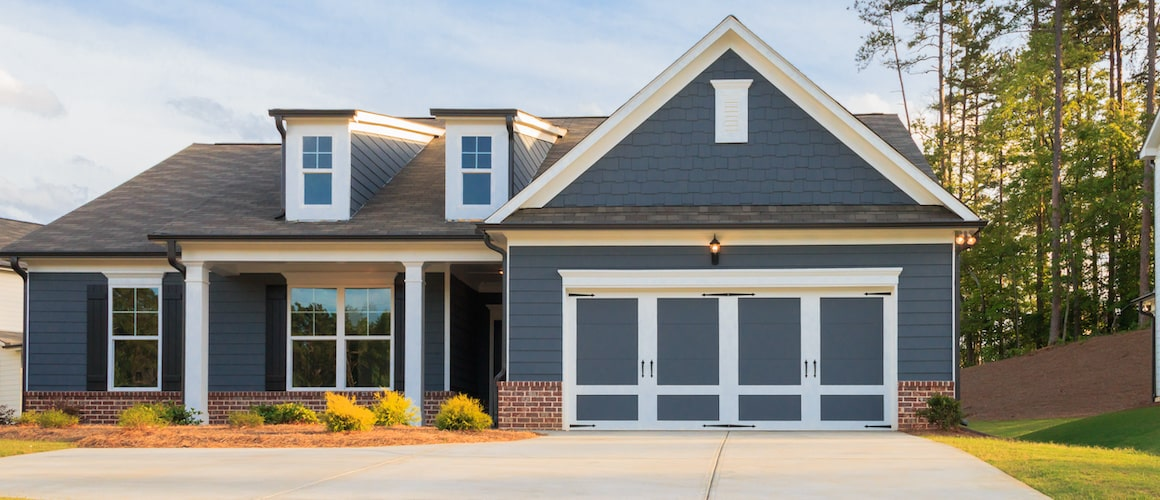

In [3]:
from IPython.display import Image
print('This is my query image')
Image(filename="house.jpg")

In [4]:
from PIL import Image
from open_clip import create_model_and_transforms, tokenizer
import torch.nn.functional as F

model, _, preprocess = create_model_and_transforms('ViT-B/32', pretrained='openai') ## Create CLIP model with Vit-B/32 and pretrained openai

# This converts the image to a tensor
image = preprocess(Image.open("house.jpg")).unsqueeze(0)

# This calculates the query embedding
query_embedding = F.normalize(model.encode_image(image)) # create embedding through encode model preprocessing image 
# Normalize created embedding to make 1D vector

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/open_clip/factory.py:372: UserWarning: These pretrained weights were trained with QuickGELU activation but the model config does not have that enabled. Consider using a model config with a "-quickgelu" suffix or enable with a flag.
  warnings.warn(


In [10]:
import pandas as pd
import numpy as np
import torch
# Retrieve the image path that corresponds to the embedding in `df`
# with the highest cosine similarity to query_embedding

# Calculate cosine similarities
cosine_similarities = F.cosine_similarity(query_embedding, torch.tensor(df['embedding'].tolist()))
print(cosine_similarities)

# Find the index of the highest similarity
highest_index = torch.argmax(cosine_similarities).item()
print(highest_index)
impath = df['file_name'].iloc[highest_index]

tensor([0.5210, 0.4137, 0.3994,  ..., 0.3191, 0.3730, 0.3899],
       grad_fn=<SumBackward1>)
67990


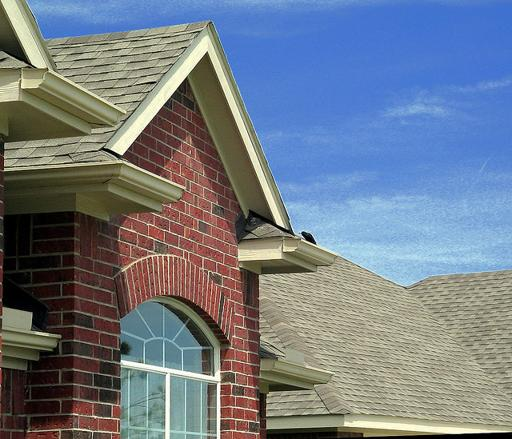

In [12]:
from IPython.display import Image
folder_path = 'coco_images_resized/'
impath = folder_path + impath
Image(filename=impath)

### Step 3: Text-to-Image Search

Now implement text-to-image-search.

The only difference here is that the query is a string of text. You will use the text encoder to obtain the corresponding query embedding.

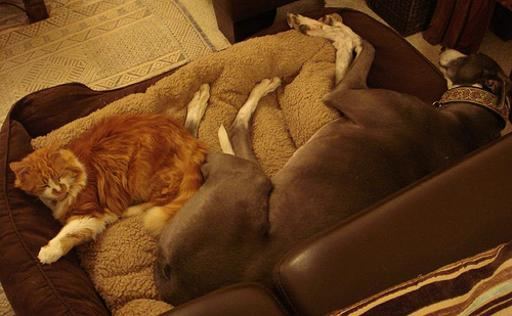

In [14]:
import open_clip

tokenizer = open_clip.get_tokenizer('ViT-B-32')
model.eval()
text = tokenizer(["cat cuddles with dog on sofa."])
query_embedding = F.normalize(model.encode_text(text)) ### encode text

# Retrieve the image path that corresponds to the embedding in `df`
# with the highest cosine similarity to query_embedding

# Calculate cosine similarities with image enbeddings
cosine_similarities = F.cosine_similarity(query_embedding, torch.tensor(df['embedding'].tolist()))
highest_index = torch.argmax(cosine_similarities).item() 
impath = folder_path + df['file_name'].iloc[highest_index]

from IPython.display import Image
Image(filename=impath)

### Step 4:  Hybrid Query

A more interesting query could contain both image and text.

For example, instead of explicitly searching for an "image of snowy house", you could search for "snowy" + an image of a house.


In this case, you should embed both the text query and the image query. Then, the query embedding is a weighted average of the two embeddings.

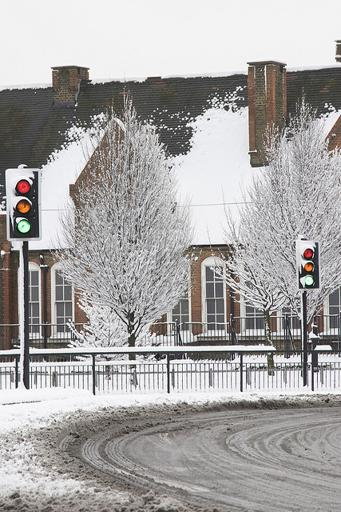

In [15]:
from PIL import Image

image = preprocess(Image.open("house.jpg")).unsqueeze(0)
image_query = F.normalize(model.encode_image(image))
text = tokenizer(["snowy"])
text_query = F.normalize(model.encode_text(text))

lam  = 0.8 # tune this

query = F.normalize(lam * text_query + (1.0 - lam) * image_query)

# Calculate cosine similarities with image embeddings
cosine_similarities = F.cosine_similarity(query, torch.tensor(df['embedding'].tolist()))

# Find the index of the highest similarity
highest_index = torch.argmax(cosine_similarities).item()  # .item()을 사용하여 정수로 변환

impath = folder_path + df['file_name'].iloc[highest_index]

from IPython.display import Image
Image(filename=impath)